In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import math
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from tensorflow.keras.optimizers import Adam
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, f1_score
plt.style.use("seaborn-v0_8")
from sklearn.preprocessing import MinMaxScaler

In [ ]:

# === Step 1: Load CSV ===
csv_path = "/content/DMC2_S_CP2_52.csv"
df = pd.read_csv(csv_path)
print("✅ Step 1 - Loaded CSV Shape:", df.shape)

# === Step 2: Extract 'CURRENT|6' column as univariate input x ===
target_col = "CURRENT|6"

x = df[[target_col]].values  # shape: (T, 1)
print("✅ Step 2 - Extracted x shape:", x.shape)

# === Step 3: Normalize x using MinMaxScaler ===
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
print("✅ Step 3 - Normalized x. Shape:", x_scaled.shape)



✅ Step 1 - Loaded CSV Shape: (42016, 56)
✅ Step 2 - Extracted x shape: (42016, 1)
✅ Step 3 - Normalized x. Shape: (42016, 1)


In [ ]:
# === Step 4: Create sliding windows ===
dim = 16          # Model dimension (used for projecting input)
window_size = 60

def create_sliding_windows(data, window_size):
    return np.array([data[i:i + window_size] for i in range(len(data) - window_size)])

# shape: [N_windows, window_size, 1]
X_all = create_sliding_windows(x_scaled, window_size)
print("✅ Step 4 - Created sliding windows. Shape:", X_all.shape)

✅ Step 4 - Created sliding windows. Shape: (41956, 60, 1)


In [ ]:
# === Step 5: Chronological Train-Test Split (60% - 40%) ===
n_total = X_all.shape[0]
n_train = int(n_total * 0.6)

X_train = X_all[:n_train]  # First 60%
X_test = X_all[n_train:]   # Remaining 40%

print("✅ Step 5 - Train/Test split")
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# === Step 6: Convert to PyTorch tensors ===
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # [B, T, 1]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

print("\n\n✅ Step 6 - Converted to torch tensors.")
print("X_train_tensor:", X_train_tensor.shape)
print("X_test_tensor :", X_test_tensor.shape)

✅ Step 5 - Train/Test split
Train shape: (25173, 60, 1)
Test shape : (16783, 60, 1)


✅ Step 6 - Converted to torch tensors.
X_train_tensor: torch.Size([25173, 60, 1])
X_test_tensor : torch.Size([16783, 60, 1])


## Config , Hyperparameters

In [ ]:
# 🧠 hyperparameters & Config
FEATS = 1                  # Input feature dimension
DIM_FEEDFORWARD = 64       # Hidden units in FFN
NUM_HEADS = 1              # Attention heads (must divide D_MODEL)
NUM_ENCODER_LAYERS = 1     # Transformer encoder layers
NUM_DECODER_LAYERS = 1     # Transformer decoder layers
DROPOUT = 0.1              # Dropout rate

D_MODEL = dim
window_size = window_size

batch_size = 128
num_epochs = 50
lr = 0.001
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # create the folder if it doesn't exist


print("\nDONE - Config")

print("\n\n✅ Step 7 - Recheck Dim and W_size.")
print("Dim :", D_MODEL)
print("Window_size :", window_size)


DONE - Config


✅ Step 7 - Recheck Dim and W_size.
Dim : 16
Window_size : 60


## Model

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create sinusoidal positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices, cosine to odd indices
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term[:(d_model // 2 + 1)])  # handles both even/odd d_model

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Add positional encoding to input tensor
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class PeakAD_Transformer(nn.Module):
    def __init__(self):
        super().__init__()

        # Project input features into higher dimension
        self.input_proj = nn.Linear(FEATS, D_MODEL)

        # Add positional encoding for combined input + error sequence
        self.pos_encoder = PositionalEncoding(D_MODEL * 2, DROPOUT, window_size)

        # Define encoder block
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=D_MODEL * 2,
            nhead=NUM_HEADS,
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=DROPOUT,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_ENCODER_LAYERS)

        # Define decoder block
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=D_MODEL * 2,
            nhead=NUM_HEADS,
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=DROPOUT,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=NUM_DECODER_LAYERS)

        # Output layer to project back to original feature dimension
        self.output_layer = nn.Sequential(
            nn.Linear(D_MODEL * 2, FEATS),
            nn.Sigmoid()
        )

    def encode(self, src, err, tgt):
        # Project source and error
        src_enc = self.input_proj(src)
        err_enc = self.input_proj(err)

        # Concatenate source and error for self-conditioning
        combined = torch.cat((src_enc, err_enc), dim=2)
        combined = combined * math.sqrt(D_MODEL)

        # Add positional encoding
        encoded = self.pos_encoder(combined)

        # Pass through transformer encoder
        memory = self.encoder(encoded)

        # Project and duplicate target for decoding
        tgt_proj = self.input_proj(tgt)
        tgt_combined = torch.cat((tgt_proj, tgt_proj), dim=2)

        return tgt_combined, memory

    def forward(self, src, tgt):
        # Phase 1: Without anomaly signal
        err = torch.zeros_like(src)
        tgt1, mem1 = self.encode(src, err, tgt)
        x1 = self.output_layer(self.decoder(tgt1, mem1))

        # Phase 2: With self-conditioning using reconstruction error
        err = (x1 - src) ** 2
        tgt2, mem2 = self.encode(src, err, tgt)
        x2 = self.output_layer(self.decoder(tgt2, mem2))

        return x2  # Final reconstructed sequence

## Model Training

In [ ]:

model = PeakAD_Transformer()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)

# previous checkpoint to resume from
start_epoch = 1  # default

# Find checkpoint files matching current config
checkpoint_files = [f for f in os.listdir(checkpoint_dir)
                    if f"Ws{window_size}_Dim{D_MODEL}" in f]

# Load latest checkpoint if available
if checkpoint_files:
    # Sort files based on the epoch number extracted correctly from the filename
    latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split("_")[2]))[-1]

    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    print(f"🔁 Resuming training from epoch {start_epoch} (loaded {latest_checkpoint})")

# Training loop
model.train()
for epoch in range(start_epoch, num_epochs + 1):
    print("Training Started")
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        x2 = model(xb, xb)
        loss = criterion(x2, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss:.4f}")

    # Save checkpoint every 50 epochs
    if epoch % 10 == 0 or epoch == num_epochs:
        ckpt_path = f"checkpoint_epoch_{epoch}_Ws{window_size}_Dim{D_MODEL}.pt"
        checkpoint_path = os.path.join(checkpoint_dir, ckpt_path)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved at: {checkpoint_path}")

print("DONE: Training complete")

🔁 Resuming training from epoch 51 (loaded checkpoint_epoch_50_Ws60_Dim16.pt)
DONE: Training complete


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


## Plot RE

In [ ]:
def plot_reconstruction_errors_per_timestep(model, scaler, X_input, threshold_percentile=98):
    model.eval()
    with torch.no_grad():
        # Reconstruct using model
        recon = model(X_input, X_input)  # [B, T, 1]

        # Use only the last timestep of each reconstructed sequence
        recon_last = recon[:, -1, 0].cpu().numpy()
        true_last = X_input[:, -1, 0].cpu().numpy()

        # Inverse transform back to original scale
        recon_orig = scaler.inverse_transform(recon_last.reshape(-1, 1)).flatten()
        true_orig = scaler.inverse_transform(true_last.reshape(-1, 1)).flatten()

        # Compute absolute reconstruction error per last timestamp
        errors = np.abs(true_orig - recon_orig)

        # Compute threshold based on specified percentile
        threshold = np.percentile(errors, threshold_percentile)

        # Detect peaks
        peaks = [i for i, e in enumerate(errors) if e > threshold]

        # Plot
        plt.figure(figsize=(14, 6))
        plt.plot(errors, label="Reconstruction Error (Last Timestep)", alpha=0.8)
        plt.axhline(threshold, color="red", linestyle="--", label=f"{threshold_percentile}th percentile")
        plt.scatter(peaks, [errors[i] for i in peaks], color='red', s=10, label="Detected Peaks")

        plt.xticks(ticks=np.arange(0, len(errors), 300), rotation=90)
        plt.title("Tran-PD: Peak Detection via Reconstruction Error")
        plt.xlabel("Window Index")
        plt.ylabel("Reconstruction Error")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save plot
        plot_filename = f"reconsn_errors_Ws{window_size}_Dim{D_MODEL}.png"
        plt.savefig(plot_filename)
        print(f"📸 Plot saved as: {plot_filename}")
        plt.show()

        return errors, peaks, true_orig, recon_orig, threshold

📸 Plot saved as: reconsn_errors_Ws60_Dim16.png


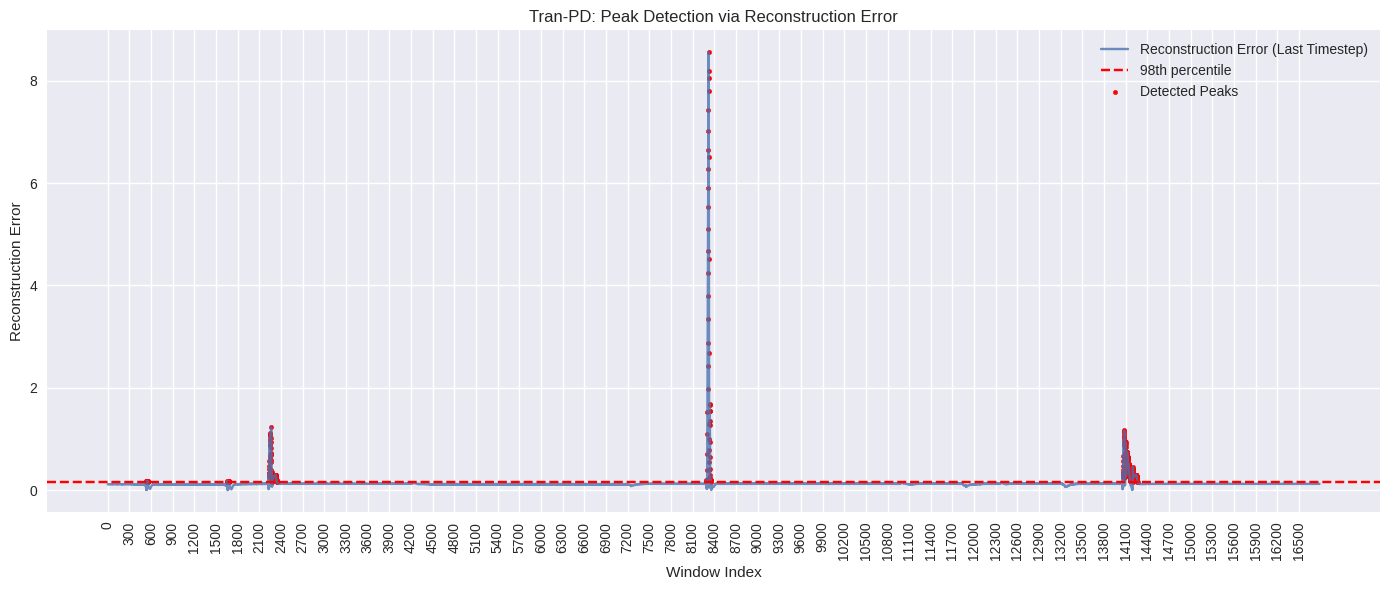

0.15658577

 DONE - 336 Peaks Detected in WINDOW_SIZE - 60, D-MODEL - 16 


In [ ]:
errors, peaks, true_orig, recon_orig, threshold = plot_reconstruction_errors_per_timestep(
    model, scaler, X_test_tensor)
### num_of_peaks
num_of_peaks = len(peaks)
print(threshold)

print(f"\n DONE - {len(peaks)} Peaks Detected in WINDOW_SIZE - {window_size}, D-MODEL - {D_MODEL} ")

### Save PEaks to Dataset

In [ ]:
start_index = window_size
timestamp_indices = np.arange(start_index, start_index + len(true_orig))

# Create the Peaks dataset
Peaks = pd.DataFrame({
    'Timestamp': timestamp_indices,
    'True_Value': true_orig,
    'Reconstructed_Value': recon_orig,
    'Reconstruction_Error': errors,
    'Peak': (errors > threshold).astype(int),
})

Peaks.to_csv(f"/content/Peaks_Ws{window_size}_Dim{D_MODEL}.csv", index=False)
print("Saved Peaks dataset to: /content/Peaks.csv")

Saved Peaks dataset to: /content/Peaks.csv


In [ ]:
### Peaks Summary

In [ ]:
print("📊 Peak Detection Summary")
print(f"Number of Peaks Detected : {len(peaks)}")
print(f"Window Size              : {window_size}")
print(f"D_MODEL                  : {D_MODEL}")
print(f"Threshold                : {threshold:.6f}")
print(f"Mean Reconstruction Error: {np.mean(errors):.6f}")
print(f"Max Reconstruction Error : {np.max(errors):.6f}")
print(f"Min Reconstruction Error : {np.min(errors):.6f}")
print("-" * 40)

📊 Peak Detection Summary
Number of Peaks Detected : 336
Window Size              : 60
D_MODEL                  : 16
Threshold                : 0.156586
Mean Reconstruction Error: 0.132526
Max Reconstruction Error : 8.559402
Min Reconstruction Error : 0.001244
----------------------------------------
